In [ ]:
import kagglehub
kagglehub.login()

!pip install bidict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models
from torch.utils.data import DataLoader, RandomSampler, random_split
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2 as cv
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR, CosineAnnealingWarmRestarts, OneCycleLR, ReduceLROnPlateau
from bidict import bidict
import gc
import torch.nn.init as init
import numpy as np
from tqdm import tqdm
from torchsummary import summary
import time
import copy
from sklearn.utils.class_weight import compute_class_weight
from torchvision.transforms import v2
from torch.utils.data import default_collate
import random

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
vladimirstratulat_asl_licenta_dataset_path = kagglehub.dataset_download("vladimirstratulat/asl-cropped-images")
print('Data source import complete.', vladimirstratulat_asl_licenta_dataset_path)

num_classes = 24
# Mean: tensor([0.5797, 0.5104, 0.4846])
# Std: tensor([0.1804, 0.1845, 0.1883])

mean = [0.5797, 0.5104, 0.4846]
#mean = [0.485, 0.456, 0.406] #pretrained

std = [0.1804, 0.1845, 0.1883]
#std = [0.229, 0.224, 0.225] #pretrained


############################################
train_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.4),
    A.Blur(blur_limit=(3, 3), p=0.3),
    A.GaussNoise(std_range=[0.05, 0.07], noise_scale_factor=0.7, p=0.3),
    A.ColorJitter(brightness=[0.8, 1.2],
                   contrast=[0.8, 1.2],
                   saturation=[0.8, 1.2], hue=[-0.3, 0.3], p=0.4),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])
############################################
valid_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])
class AlbumentationsDataset(datasets.ImageFolder):
    def __init__(self, root, transform):
        super().__init__(root)
        self.transform = transform

    def __getitem__(self, index):
        path, label = self.samples[index]
        image = cv.imread(path)  # Read image
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = self.transform(image=image)["image"]  # Apply Albumentations
        return image, label

def plot_images(images, labels):
  for image, label in zip(images, labels):
    npy_image = image.permute(1, 2, 0).numpy()
    npy_image = npy_image * std + mean
    plt.imshow(npy_image)
    plt.title(classes[label.item()])
    plt.show()

def annotate_points(x, y):
    for i, txt in enumerate(y):
        plt.annotate(f"{txt:.2f}", (x[i], y[i]), textcoords="offset points", xytext=(5,5), ha='center')

def plot_acc_and_loss(train_loss, train_acc, val_loss, val_acc, epochs, lr):
  plt.figure(figsize=(8, 5))
  plt.plot(epochs, train_loss, label="Train Loss", marker="o", linestyle="-")
  plt.plot(epochs, train_acc, label="Train Accuracy", marker="s", linestyle="--")

  annotate_points(epochs, train_loss)
  annotate_points(epochs, train_acc)

  plt.xlabel("Epochs")
  plt.ylabel("Loss / Accuracy")
  plt.title(f"Training Loss and Accuracy. LR - {lr:.6f}")
  plt.legend()
  plt.grid(True)
  plt.show()

  # Plot Validation Loss and Accuracy
  plt.figure(figsize=(8, 5))
  plt.plot(epochs, val_loss, label="Validation Loss", marker="o", linestyle="-")
  plt.plot(epochs, val_acc, label="Validation Accuracy", marker="s", linestyle="--")

  annotate_points(epochs, val_loss)
  annotate_points(epochs, val_acc)

  plt.xlabel("Epochs")
  plt.ylabel("Loss / Accuracy")
  plt.title("Validation Loss and Accuracy")
  plt.legend()
  plt.grid(True)
  plt.show()


folder_root = "/root/.cache/kagglehub/datasets/vladimirstratulat/asl-cropped-images/versions/1/ASL_CROPPED_IMAGES"
train_dataset = AlbumentationsDataset(root=f"{folder_root}/train", transform=train_transforms)
validate_dataset = AlbumentationsDataset(root=f"{folder_root}/validate", transform=valid_transforms)

cutmix = v2.CutMix(num_classes=num_classes)
mixup = v2.MixUp(num_classes=num_classes)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

mixup_or_cutmix_p = 0.5
def collate_fn(batch):
  return cutmix_or_mixup(*default_collate(batch)) if random.random() < mixup_or_cutmix_p else default_collate(batch)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True, collate_fn=collate_fn)

val_dataset_size = len(validate_dataset)
split1 = int(val_dataset_size * 0.5)
split2 = val_dataset_size - split1
split_datasets = random_split(validate_dataset, [split1, split2], generator=torch.Generator().manual_seed(42))

test_loader = DataLoader(split_datasets[1], batch_size=batch_size, shuffle=False)
validate_loader = DataLoader(split_datasets[0], batch_size=batch_size, num_workers=12, shuffle=True)
classes = bidict({i: letter for i, letter in enumerate(train_dataset.classes)})
print(len(classes))

100%|██████████| 2.59G/2.59G [02:10<00:00, 21.3MB/s]

Extracting files...


Data source import complete. /root/.cache/kagglehub/datasets/vladimirstratulat/asl-cropped-images/versions/1
24


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
           nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=2, padding=2), nn.BatchNorm2d(16), nn.ReLU(),
           nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2), nn.BatchNorm2d(32), nn.ReLU(),
           nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
           nn.MaxPool2d(2, 2),

           nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(48), nn.ReLU(),
           nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
           nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64),  nn.ReLU(),
           nn.MaxPool2d(2, 2),

           nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(96), nn.ReLU(),
           nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(96), nn.ReLU(),
           nn.MaxPool2d(2, 2),

           nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
           nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
           nn.MaxPool2d(2, 2),

           nn.Conv2d(in_channels=128, out_channels=160, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(160), nn.ReLU(),
           nn.Conv2d(in_channels=160, out_channels=160, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(160), nn.ReLU(),

           nn.AdaptiveAvgPool2d(1)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(160, 64), nn.ReLU(), nn.Dropout(0.45),
            nn.Linear(64, 24)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)

        return self.fc_layers(x)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                init.zeros_(m.bias)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_weights = torch.tensor([0.0005694760820045558, 0.0005714285714285715, 0.0005733944954128441, 0.000555247084952804,
                              0.0005817335660267597, 0.0005707762557077625, 0.0005844535359438924, 0.0005750431282346176,
                              0.0005720823798627002, 0.0005773672055427252, 0.000572737686139748, 0.0005720823798627002,
                              0.0005701254275940707, 0.0006666666666666666, 0.0005698005698005698, 0.0007547169811320754,
                              0.000576036866359447, 0.0005730659025787965, 0.0005733944954128441, 0.0005730659025787965,
                              0.0005730659025787965, 0.000572737686139748, 0.0005730659025787965, 0.0005720823798627002,
                              0.0005717552887364208]).to(device)
class_weights = class_weights / class_weights.min()
model = CNN().to(device)
model_name = "SimpleCNN"
# model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT).to(device)
# model.classifier = nn.Sequential(
#     nn.Linear(960, 96), nn.Hardswish(), nn.Dropout(0.3),
#     nn.Linear(96, num_classes)
# ).to(device)


model.load_state_dict(torch.load("/content/drive/MyDrive/Colab/experiments/experiment_SimpleCNN_20250531_222446_92.27414330218069.pth"))

# import io
# from contextlib import redirect_stdout

# summary_str = io.StringIO()
# with redirect_stdout(summary_str):
#     summary(model, input_size=(3, 224, 224))


# model_summary_text = summary_str.getvalue()
# print(model, model_summary_text)



<All keys matched successfully>

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Finished validation in epoch 1. Avg Loss: 1.13092931. Final validation accuracy: 91.06%, LR: 0.001


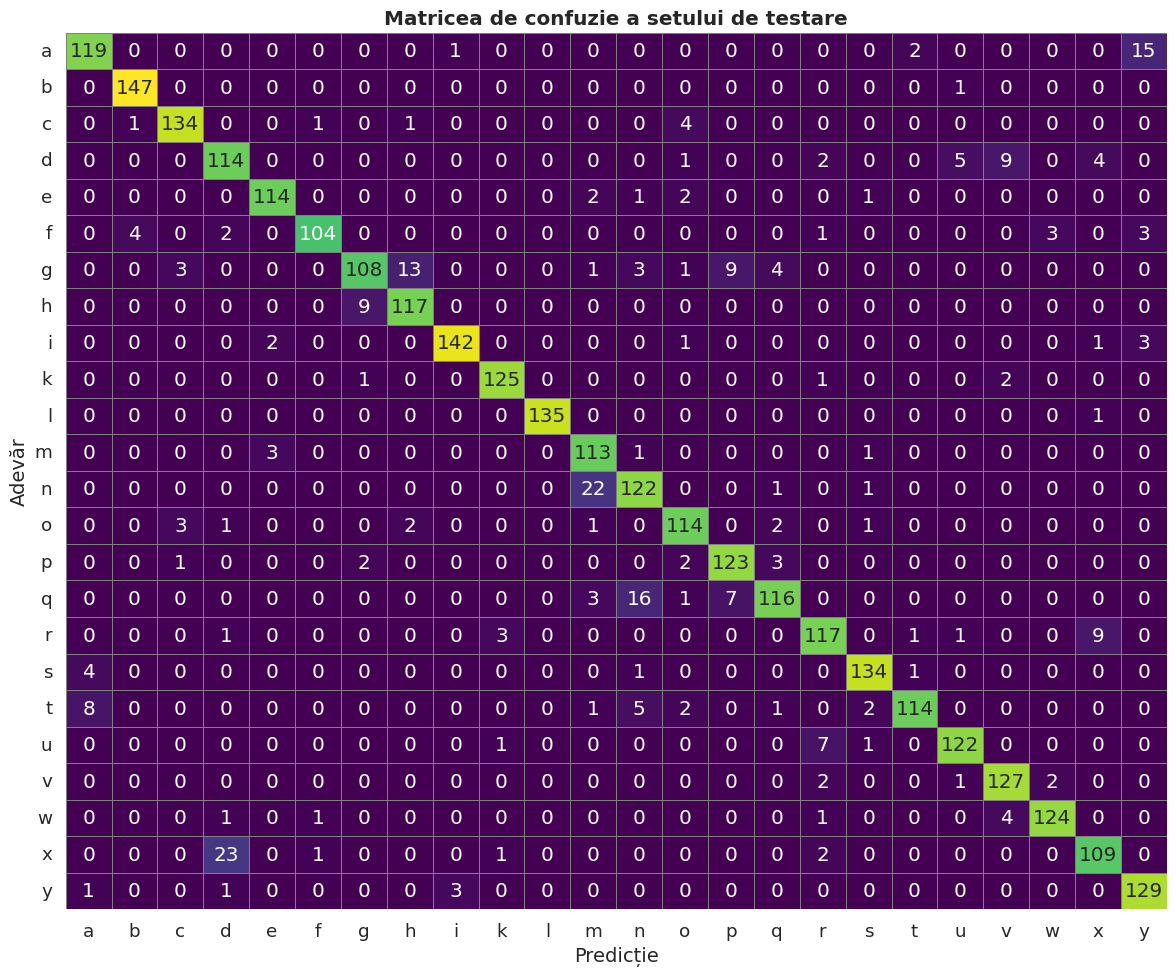

Classification Report:

              precision    recall  f1-score   support

           a       0.90      0.87      0.88       137
           b       0.97      0.99      0.98       148
           c       0.95      0.95      0.95       141
           d       0.80      0.84      0.82       135
           e       0.96      0.95      0.95       120
           f       0.97      0.89      0.93       117
           g       0.90      0.76      0.82       142
           h       0.88      0.93      0.90       126
           i       0.97      0.95      0.96       149
           k       0.96      0.97      0.97       129
           l       1.00      0.99      1.00       136
           m       0.79      0.96      0.87       118
           n       0.82      0.84      0.83       146
           o       0.89      0.92      0.90       124
           p       0.88      0.94      0.91       131
           q       0.91      0.81      0.86       143
           r       0.88      0.89      0.88       132
   

In [ ]:
num_epochs = 1
lr = 1e-3
label_smoothing = 0.15
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-6)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-6)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# if isinstance(model, CNN):
#   model.apply(CNN.init_weights)

eta_min = 1e-5

#scheduler = ReduceLROnPlateau(optimizer, patience=5, min_lr=eta_min, factor=0.9)
#scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=eta_min, T_mult=3)
#scheduler = None
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=eta_min)

train_accuracies, train_losses = [], []
validation_accuracies, validation_losses = [], []
for epoch in range(num_epochs):
    #### Train ####
    # model.train()

    # total_correct_train = 0
    # cum_loss = 0.0
    # total_train_samples = 0
    # progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch+1}/{num_epochs}...", leave=False)

    # for images, labels in progress_bar:
    #     # plot_images(images, labels)
    #     images, labels = images.to(device), labels.to(device)
    #     optimizer.zero_grad()
    #     outputs = model(images)
    #     if labels.dim() > 1:  # Only apply argmax if labels are in one-hot format
    #       labels = labels.argmax(dim=1)

    #     loss = criterion(outputs, labels)
    #     loss.backward()
    #     optimizer.step()



    #     predicted = outputs.argmax(dim=1)
    #     total_correct_train += (predicted == labels).sum().item()
    #     batch_size = len(labels)
    #     total_train_samples += batch_size

    #     cum_loss += loss.item() * batch_size

    #     cum_acc = total_correct_train / total_train_samples * 100

    #     running_avg_loss = cum_loss / total_train_samples

    #     progress_bar.set_postfix(Loss=f"{running_avg_loss:.8f}", Accuracy=f"{cum_acc:.2f}%")

    # epoch_avg_loss = cum_loss / total_train_samples
    # epoch_acc = total_correct_train / len(train_loader.dataset) * 100
    # train_accuracies.append(epoch_acc)
    # train_losses.append(epoch_avg_loss)
    # print(f"Finished training in epoch {epoch + 1}. Avg Loss: {epoch_avg_loss:.8f}. Final train accuracy: {epoch_acc:.2f}%.")

    #### Validation ####
    model.eval()

    total_validate_samples = 0
    cum_loss = 0.0
    total_correct_validate = 0

    progress_bar = tqdm(test_loader, desc=f"Validating epoch {epoch + 1}/{num_epochs}", leave=False)
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in progress_bar:
            #plot_images(images, labels)
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            predicted = outputs.argmax(dim=1)
            batch_correct = (predicted == labels).sum().item()
            batch_size = len(labels)


            total_correct_validate += batch_correct
            total_validate_samples += batch_size
            cum_loss += loss.item() * batch_size

            cum_acc = total_correct_validate / total_validate_samples * 100
            running_avg_loss = cum_loss / (total_validate_samples)

            progress_bar.set_postfix(Loss=f"{running_avg_loss:.8f}", Accuracy=f"{cum_acc:.2f}%")
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

        avg_validate_loss = cum_loss / total_validate_samples
        validation_accuracy = total_correct_validate / len(validate_loader.dataset) * 100

        if validation_accuracies and validation_accuracy > max(validation_accuracies):
          best_model = copy.deepcopy(model.state_dict())
        validation_accuracies.append(validation_accuracy)
        validation_losses.append(avg_validate_loss)
        curr_lr = scheduler.get_last_lr()[0] if scheduler else lr
        print(f"Finished validation in epoch {epoch + 1}. Avg Loss: {avg_validate_loss:.8f}. Final validation accuracy: {validation_accuracy:.2f}%, LR: {curr_lr}")
    #plot_acc_and_loss(train_loss=train_losses, train_acc=train_accuracies, val_loss=validation_losses, val_acc=validation_accuracies, epochs=np.arange(len(train_losses)), lr=curr_lr)
    if scheduler:
      scheduler.step()
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred)
    labels = [classes[i] for i in range(len(classes))]

    plt.figure(figsize=(12, 10))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
                xticklabels=labels, yticklabels=labels,
                linewidths=0.5, linecolor='gray', cbar=False)

    plt.title("Matricea de confuzie a setului de testare", fontweight='bold')
    plt.xlabel("Predicție", fontsize=14)
    plt.ylabel("Adevăr", fontsize=14)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Classification report
    report = classification_report(y_true, y_pred, target_names=labels, digits=2)
    print("Classification Report:\n")
    print(report)

print(f"MAX VALIDATION ACC: {max(validation_accuracies):.4f}")

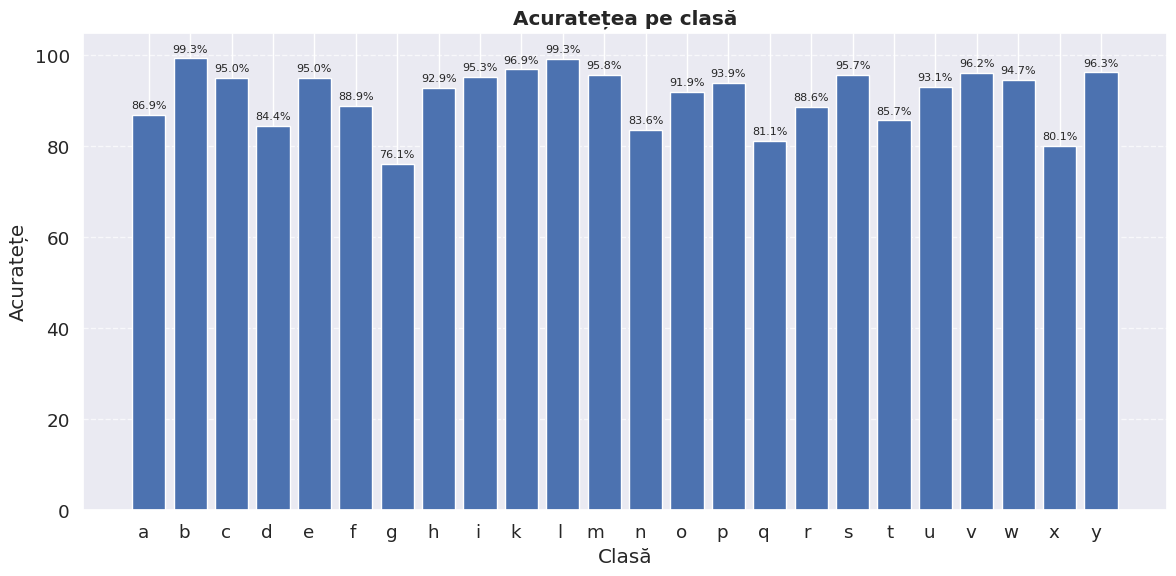

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_pred = np.array(y_pred)
y_true = np.array(y_true)

accuracies = []
for i in range(24):
    idx = np.where(y_true == i)[0]
    correct = (y_pred[idx] == i).sum()
    total = len(idx)
    acc = correct / total if total > 0 else 0
    accuracies.append(acc * 100)  # în procente

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
bars = plt.bar(classes.values(), np.array(accuracies))

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1,  # x, y
             f"{height:.1f}%", ha='center', va='bottom', fontsize=8)

plt.ylabel("Acuratețe")
plt.xlabel("Clasă")
plt.title("Acuratețea pe clasă", fontweight='bold')
plt.xticks(ha='right')
plt.ylim(0, 105)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




In [ ]:
import json
import datetime
import uuid

def save_experiment(model, params, augmentations, train_losses, train_accuracies, val_losses, val_accuracies):
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"/content/drive/MyDrive/Colab/experiments/experiment_{params['model_name']}_{timestamp}.json"
    torch.save(best_model, f"/content/drive/MyDrive/Colab/experiments/experiment_{params['model_name']}_{timestamp}_{max(validation_accuracies)}.pth")
    data = {
        "model_architecture": str(model),
        "model_summary": model_summary_text,
        "hyperparameters": {"params" : params,
                            "label_smoothing" : label_smoothing},
        "augmentations": {"normal_augs": augmentations.to_dict() if augmentations else None,
                          "mixup_cutmix_p" : mixup_or_cutmix_p},
        "metrics": {
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "val_losses": val_losses,
            "val_accuracies": val_accuracies
        }
    }

    with open(filename, "w") as f:
        json.dump(data, f, indent=4)

    print(f"Experiment saved to {filename} with max validation acc: {max(validation_accuracies):.4f}")

params = {
    "model_name": model_name,
    "epochs": num_epochs,
    "batch_size": batch_size,
    "learning_rate": lr,
    "optimizer": {
        "type": optimizer.__class__.__name__,
        "params": optimizer.defaults
    },
    "scheduler": {
        "type":scheduler.__class__.__name__,
        "params": scheduler.state_dict()
    } if scheduler else None
}

save_experiment(model, params, train_transforms, train_losses, train_accuracies, validation_losses, validation_accuracies)



Experiment saved to /content/drive/MyDrive/Colab/experiments/experiment_SimpleCNN_20250531_222446.json with max validation acc: 92.2741


In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

59690